In [1]:
import pickle
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.providers.fake_provider import FakeVigoV2

from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

plt.style.use("ggplot")

import sys
sys.path.append("../pauli_lindblad_per")

from primitives.pauli import QiskitPauli

backend = FakeVigoV2()

#readout-mitigated expectation values
with open("PER_results_extended.pickle", "rb") as f:
    circuit_results = pickle.load(f)

expectations = ["ZIIII", "IZIII", "IIZII", "IIIZI"]

plt.rcParams['text.usetex'] = True

In [2]:
xax = np.arange(1,16)
noise_strengths = [0,.5,1,2]

In [3]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(dt*4*h, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2, backend.num_qubits)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend)

    #Remember to fix this! Expectation values are not adjusted for inst_map in the program,
    #So I had to do this manually
    for i in range(backend.num_qubits):
        transpiled.measure(i,i) 


    return transpiled

In [4]:
def get_expecs_stdevs(noise_strength):
    expecs = []
    stdevs = []
    for result in circuit_results:
        avgs = []
        for op in expectations:
            op_expec = sum(result[noise_strength][op])/len(result[noise_strength][op])
            avgs.append(op_expec)
        expecs.append(np.mean(avgs))
        stdevs.append(np.std(avgs))
    return expecs, stdevs

## Scaling with noise
This figure shows the computed expectation value at different noise strengths with the standard deviation plotted as error bars. I could modify this plot so that there is less overlap between the lines, but I like the way you can clearly see how the curve deforms as the noise strength is changed.

Text(0, 0.5, 'Global z magnetization')

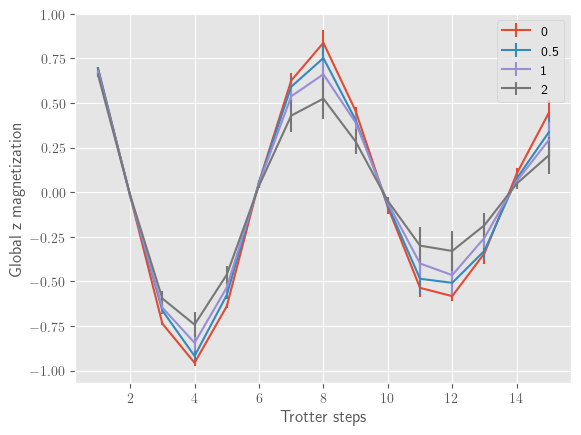

In [5]:
for ns in noise_strengths:
    expecs, stdevs = get_expecs_stdevs(ns)
    plt.errorbar(xax, expecs, stdevs)
plt.legend(noise_strengths)
plt.xlabel("Trotter steps")
plt.ylabel("Global z magnetization")

In [14]:
def plot_dist(noise_strength, ax):
    data = []
    for result in circuit_results:
        dpts = []
        for i in range(1000):
            expec = 0
            for op in expectations:
                expec += result[noise_strength][op][i]
            dpts.append(expec/4)
        data.append(dpts)
    ideal, = ax.plot(xax, ideal_expecs, color = "black", linestyle = "--", label = "Noiseless")
    for i,x in enumerate(xax):
        means = ax.errorbar(x, np.mean(data[i]), np.std(data[i]), color="tab:red", marker = "x", capsize=5, capthick = 1)
        ax.scatter([x for d in data[i]], data[i], color=(0.1, 0.2, 0.5, 0.01))
    ax.set_ylim([3,-3])
    ax.legend([means], [r"$\langle M_z \rangle$ at $\xi = "+str(noise_strength)+"$"], loc = "lower left",fontsize = 18)
    

## Measurement distribution
This is a nice figure because it illustrates what is actually going on in the PER. The blue dots show individual measurements, and the red x's show the average used to compute the expectation value. The increased negativity of the distribution in the PEC limit can be seen by comparing the locations of the dots in the `plot_dist(0)` and `plot_dist(2)` figure. Both of these use sampling, but in the latter case the distribution has no negative coefficients. The affect of the increased overhead can also be seen in the increasing y-values of the points.

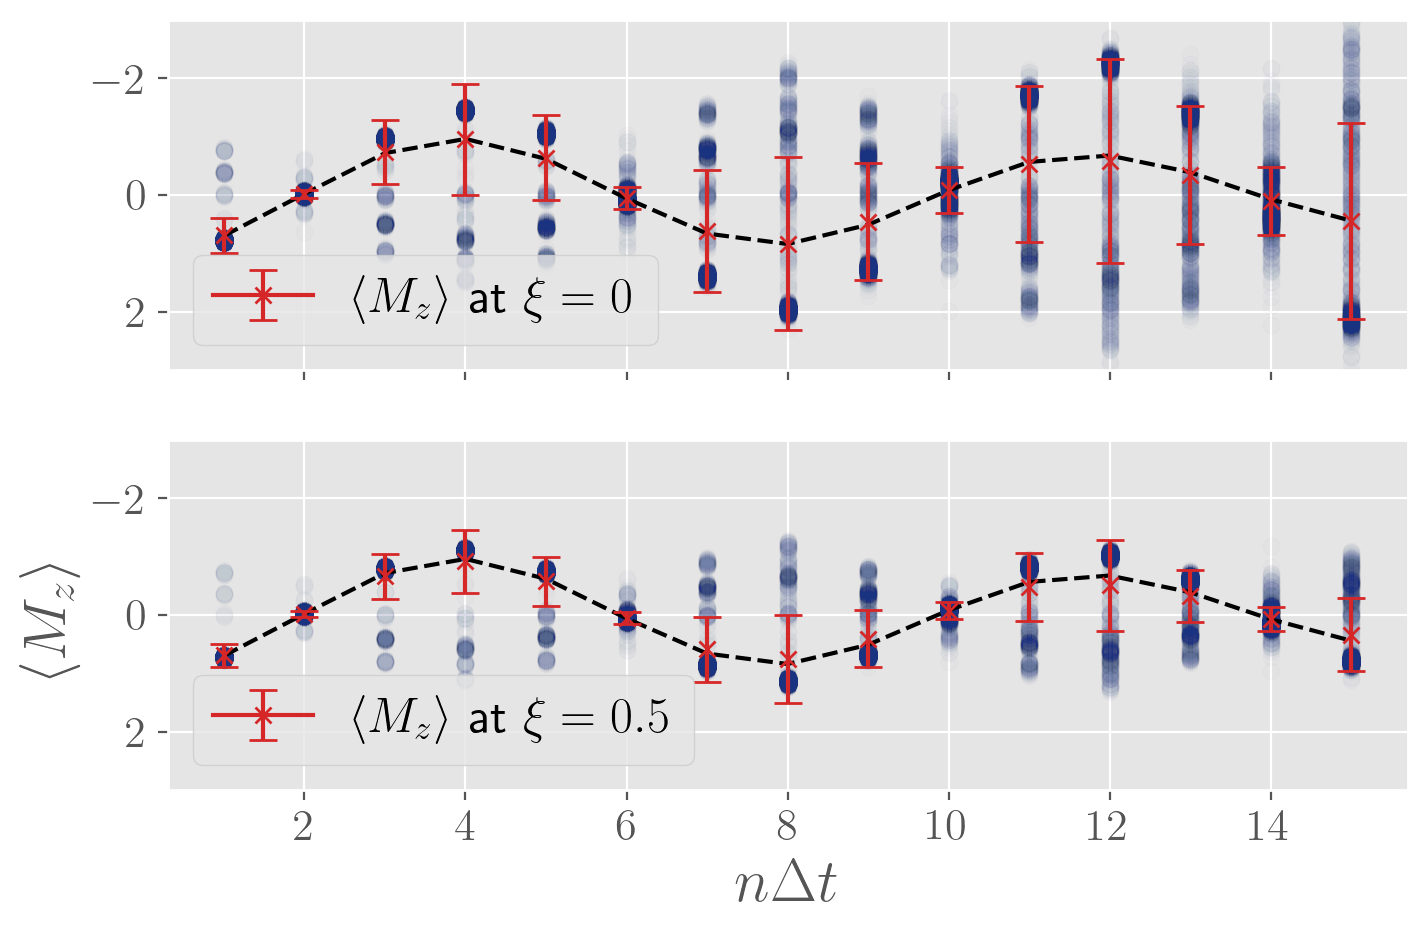

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.set_size_inches(8,5)
fig.set_dpi(200)
plt.xlabel(r"$n\Delta t$", fontsize = 22)
ax2.set_ylabel(r"$\langle M_z\rangle$", fontsize = 22)
ax1.tick_params(axis="both", labelsize = 16)
ax2.tick_params(axis="both", labelsize = 16)
plot_dist(0, ax1)
plot_dist(.5, ax2)

## Trotter simulation on noiseless backend for comparison

In [8]:
ideal_backend = Aer.get_backend("qasm_simulator")

def get_expectation(n, result):
    return sum([{True:1, False:-1}[key[n]=='0']*result[key] for key in result])/sum(result.values())

def get_z_mag(result):
    return sum([get_expectation(n, result) for n in range(4)])/4

def run_trotter(d, shots):
    circuit = maketrotterCircuit(d) 
    job = ideal_backend.run(circuit, shots = shots)
    return job.result().get_counts()

shots = 10000
ideal_expecs = [get_z_mag(run_trotter(d, shots)) for d in xax]

## Incorporate variances into fit
The fits are performed here, this time taking into account the deviations in the expectation values. The resulting error in the fit coefficients is obtained from the covariance matrix and plotted, but it is almost too small to see!

In [10]:
def single_expec_stdev(noise_strength, expec, d):
    result = circuit_results[d-1]
    expecs = result[noise_strength][expec]
    return np.mean(expecs), np.std(expecs)

expfit = lambda x,a,b: a*np.exp(-b*x)

def fit_expectation(expec, d):
    expecs = []
    sigmas = []
    ns_lvls = [.5,1,2] #exclude the 0 level to compare PER without PEC
    for ns in ns_lvls:
        exp, stdev = single_expec_stdev(ns, expec, d)
        expecs.append(exp)
        sigmas.append(stdev)

    popt, pcov = curve_fit(expfit, ns_lvls, expecs, sigma = sigmas)

    perr = np.sqrt(np.diag(pcov))

    return popt, perr

def extrapolate_z_mag(d):
    errs = []
    expecs = []
    for expec in expectations:
        popt, perr = fit_expectation(expec, d)
        a,b = popt
        da, db = perr
        expecs.append(a)
        errs.append(da)
    return np.mean(expecs), np.mean(errs)

In [11]:
extrapolated_expecs, errs = zip(*[extrapolate_z_mag(d) for d in xax])

## PER vs PEC
This next graph shows the result of using $\xi= .5, 1, 2$ and vZNE vs just using PEC with $\xi = 0$. At nine trotter steps the overhead is $\approx 3.40$. The number of samples for a fixed precision is proportional to $\gamma^2$. To keep all measurements at a fixed precision, $\gamma^2$ for PEC is around $11.56$. For PER at these noise levels, this is $3.4+1+1 = 5.4$. Assuming that the fit does not significantly amplify this error, this cuts the number of circuits needed in half. As the graph shows, the accuracy obtained with the fit actually improves on the PEC value.

Text(0, 0.5, '$\\langle M_z \\rangle$')

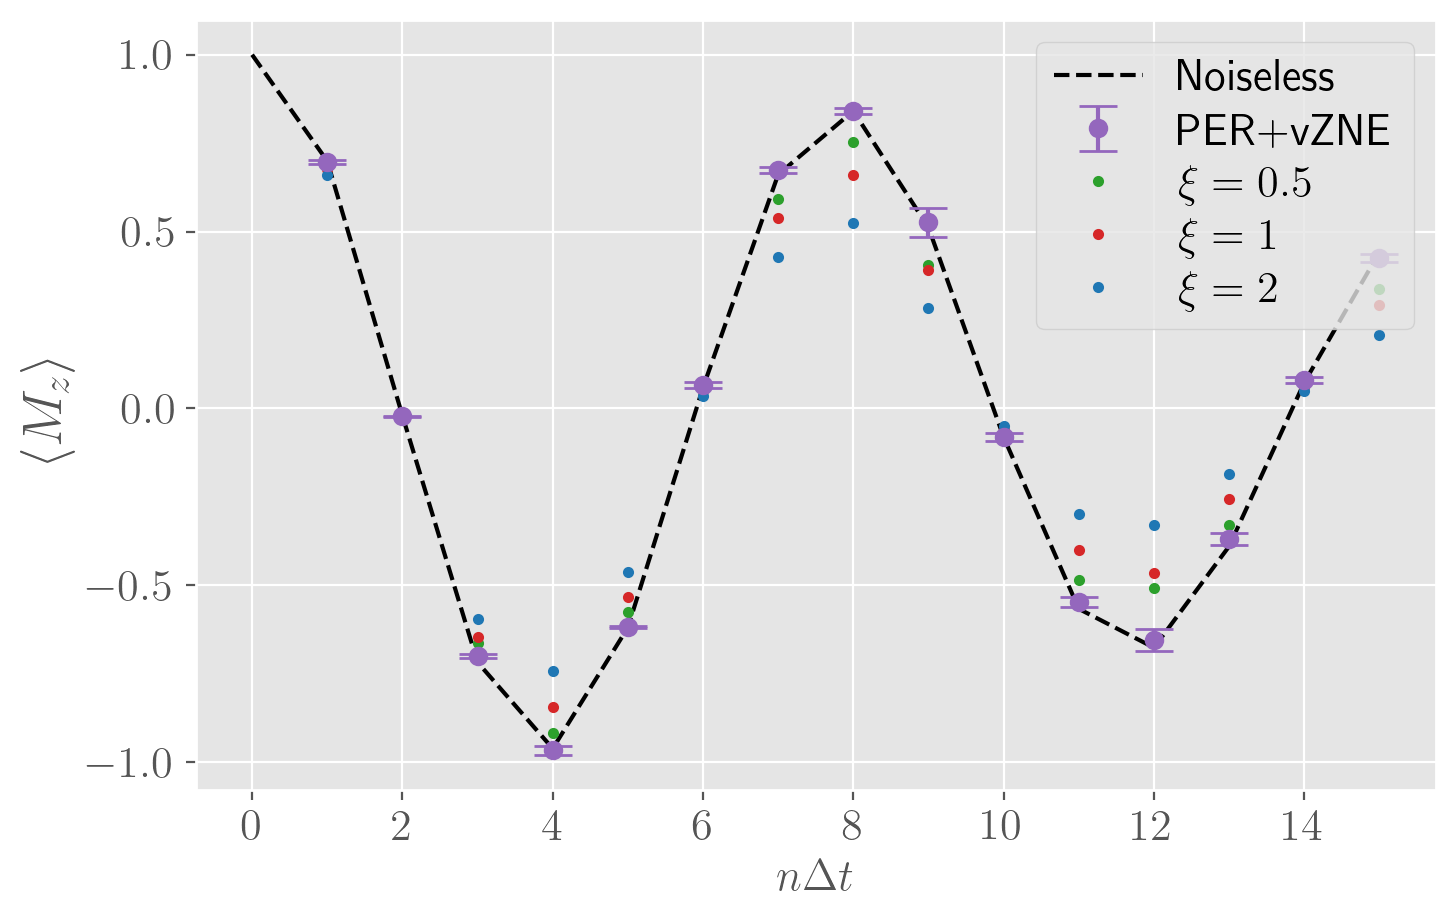

In [26]:
plt.figure(figsize=(8,5), dpi = 200)
ideal, =plt.plot([0]+list(xax),[1]+ideal_expecs, color = "black", linestyle = "--",label = "Noiseless")
PERVZNE = plt.errorbar(xax,extrapolated_expecs, errs, linestyle = "None", color = "tab:purple", marker= "o", label = "PER+vZNE", capsize = 7, capthick = 1)
point5expecs, point5stdevs = get_expecs_stdevs(.5)
point5, = plt.plot(xax, point5expecs, linestyle = "None", color = "tab:green", marker = ".", label = r"$\xi = .5$")
oneexpecs, onestdevs = get_expecs_stdevs(1)
one, = plt.plot(xax, oneexpecs, linestyle = "None", color = "tab:red", marker = ".", label = r"$\xi = 1$")
twoexpecs, twostdevs = get_expecs_stdevs(2)
two, = plt.plot(xax, twoexpecs,linestyle = "None", color = "tab:blue", marker = ".", label = r"$\xi = 2")
plt.legend([ideal, PERVZNE, point5, one, two],["Noiseless", "PER+vZNE",  r"$\xi = 0.5$", r"$\xi = 1$", r"$\xi = 2$"], fontsize = 16, ncol = 1, labelspacing = .3, columnspacing = 0)
plt.tick_params(axis='both',labelsize=16)
plt.xlabel(r"$n \Delta t$", fontsize = 16)
plt.ylabel(r"$\langle M_z \rangle$", fontsize = 20)

## Evaluating the exponential fits
The following graphs show the convergence of the expectation values. The deviations are rescaled by a factor of ten to make them easier to visualize on the plot. My hypothesis is that the variance is so much lower on the $\xi = 1$ value because more than one shot was run for each sampled instance.

In [33]:
def get_ideal_expectation(expec, d):
    expec = expec
    res = run_trotter(d, 100000)
    return get_expectation(expec.find("Z"), res)
    

def plot_expectation_convergence(expec, d, ax):
    expecs = []
    stdevs = []
    for ns in noise_strengths:
        exp, sigma = single_expec_stdev(ns, expec, d)
        expecs.append(exp)
        stdevs.append(sigma)
    xline = np.linspace(0, 2)
    ideal_expectation = get_ideal_expectation(expec,d) 
    popt, perr = fit_expectation(expec, d)
    ax.errorbar(noise_strengths, expecs, [sgma/10 for sgma in stdevs], linestyle = "None", marker= "o")
    ax.plot(xline, [expfit(x,*popt) for x in xline], linestyle = "--")
    ideal = ax.scatter(0, ideal_expectation, marker = "*", color = "black", zorder = 10, label = "Ideal", s = 100)
    ax.legend([ideal],["Noiseless"], fontsize = 22)
    ax.set_ylabel(r"$\langle %s\rangle$"%(expec[:-1]), fontsize = 22)
    ax.set_ylim([.1,.8])
    ax.set_xlabel(r"$\xi$", fontsize = 22)
        

In [34]:
depth = 15

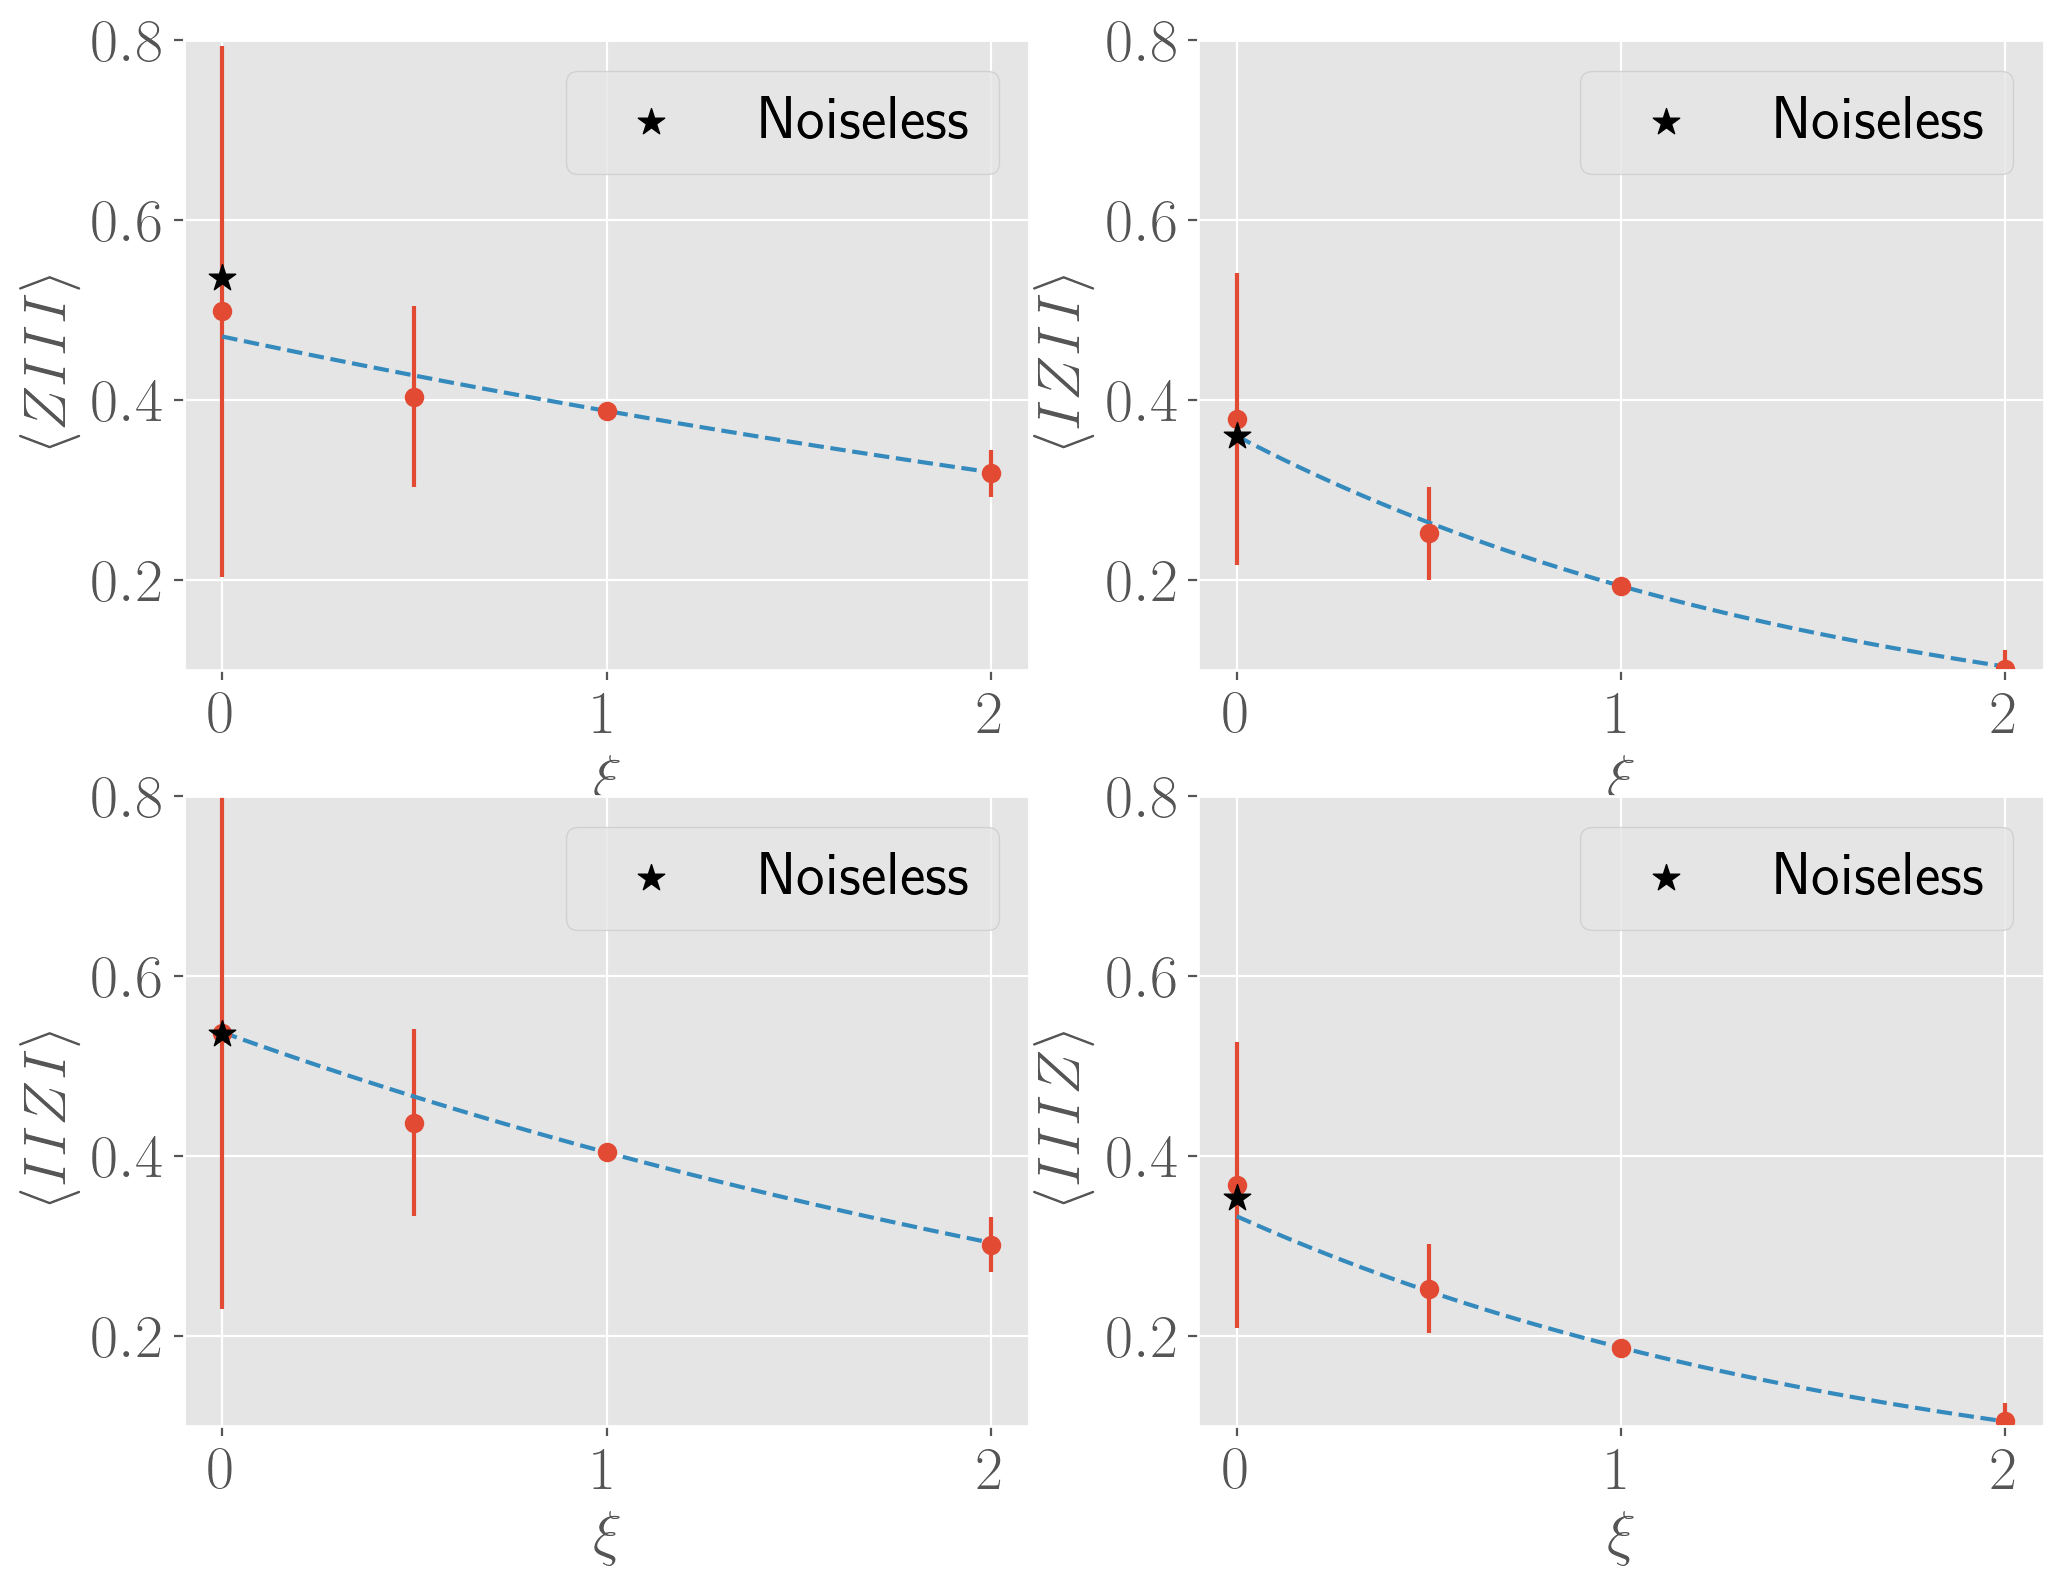

In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(12, 9)
fig.set_dpi(200)
ax1.tick_params(axis="both", labelsize=22)
ax2.tick_params(axis="both", labelsize=22)
ax3.tick_params(axis="both", labelsize=22)
ax4.tick_params(axis="both", labelsize=22)
plot_expectation_convergence("ZIIII", depth, ax1)
plot_expectation_convergence("IZIII", depth, ax2)

plot_expectation_convergence("IIZII", depth, ax3)
plot_expectation_convergence("IIIZI", depth, ax4)

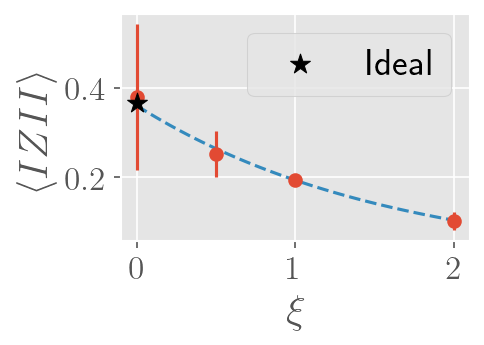

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(3,2)
fig.set_dpi(150)
ax.set_xlabel(r"$\xi$", fontsize = 20)
ax.set_ylabel(r"$\langle IZII \rangle$", fontsize = 20)
ax.tick_params(axis='both',labelsize=16)
plot_expectation_convergence("IZIII", depth, ax)